<a href="https://colab.research.google.com/github/AmrTc/bachloreArbeit/blob/main/thesis_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Evaluation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from scipy.stats import chi2_contingency, fisher_exact
import warnings
warnings.filterwarnings('ignore')

### Data cleaning process

In [ ]:
# Data Cleaning and Preprocessing Analysis

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("="*80)
print("DATA CLEANING AND PREPROCESSING ANALYSIS")
print("="*80)

# Load datasets
# Load datasets
try:
    df_comprehensive_feedback = pd.read_csv('/content/drive/MyDrive/thesis_evaluation/comprehensive_feedback_20250831_234308.csv')
    df_explanation_feedback = pd.read_csv('/content/drive/MyDrive/thesis_evaluation/explanation_feedback_20250831_234310.csv')
    df_users = pd.read_csv('/content/drive/MyDrive/thesis_evaluation/users_20250831_234325.csv')
    df_superstore = pd.read_csv('/content/drive/MyDrive/thesis_evaluation/superstore_20250831_234323.csv')
    df_chat_sessions = pd.read_csv('/content/drive/MyDrive/thesis_evaluation/chat_sessions_20250831_234307.csv')
except FileNotFoundError as e:
    print(f"Dataset loading error: {e}")
# Data cleaning process
# Remove invalid users (Admin, Test users, and users who didn't finish tasks)
users_to_remove = [1, 12, 8, 9, 17, 10, 5, 3, 2]

print(f"\nDATA CLEANING PROCESS:")
print(f"- Users to be removed: {len(users_to_remove)} (Admin, Test users, incomplete tasks)")

# Original dataset sizes
original_sizes = {
    'chat_sessions': len(df_chat_sessions),
    'comprehensive_feedback': len(df_comprehensive_feedback),
    'explanation_feedback': len(df_explanation_feedback),
    'users': len(df_users)
}

# Apply filtering
df_chat_sessions_filtered = df_chat_sessions[~df_chat_sessions['user_id'].isin(users_to_remove)]
df_comprehensive_feedback_filtered = df_comprehensive_feedback[~df_comprehensive_feedback['user_id'].isin(users_to_remove)]
df_explanation_feedback_filtered = df_explanation_feedback[~df_explanation_feedback['user_id'].isin(users_to_remove)]
df_users_filtered = df_users[~df_users['id'].isin(users_to_remove)]

# Anonymize user data by removing/masking username column
if 'username' in df_users_filtered.columns:
    df_users_filtered = df_users_filtered.copy()
    df_users_filtered['username'] = df_users_filtered.apply(lambda row: f"User_{row.name:03d}", axis=1)

filtered_sizes = {
    'chat_sessions': len(df_chat_sessions_filtered),
    'comprehensive_feedback': len(df_comprehensive_feedback_filtered),
    'explanation_feedback': len(df_explanation_feedback_filtered),
    'users': len(df_users_filtered)
}

# Calculate cleaning statistics
cleaning_stats = []
for dataset, original_size in original_sizes.items():
    filtered_size = filtered_sizes[dataset]
    removed_count = original_size - filtered_size
    removal_percentage = (removed_count / original_size) * 100 if original_size > 0 else 0

    cleaning_stats.append({
        'Dataset': dataset.replace('_', ' ').title(),
        'Original_Size': original_size,
        'Filtered_Size': filtered_size,
        'Removed_Records': removed_count,
        'Removal_Percentage': removal_percentage
    })

cleaning_df = pd.DataFrame(cleaning_stats)

# Display cleaning results
print(f"\nCLEANING RESULTS:")
print("-" * 60)
for _, row in cleaning_df.iterrows():
    print(f"{row['Dataset']:25} | Original: {row['Original_Size']:4d} | "
          f"Filtered: {row['Filtered_Size']:4d} | "
          f"Removed: {row['Removed_Records']:3d} ({row['Removal_Percentage']:5.1f}%)")

# Summary statistics table
print(f"\n" + "="*80)
print("CLEANING SUMMARY TABLE")
print("="*80)
print(cleaning_df.to_string(index=False, float_format='%.1f'))

# Data integrity checks
print(f"\n" + "="*60)
print("DATA INTEGRITY CHECKS")
print("="*60)

integrity_checks = []

# Check for missing user_id references
missing_users_chat = set(df_chat_sessions_filtered['user_id'].unique()) - set(df_users_filtered['id'].unique())
missing_users_feedback = set(df_comprehensive_feedback_filtered['user_id'].unique()) - set(df_users_filtered['id'].unique())

integrity_checks.append({
    'Check': 'Missing user references in chat_sessions',
    'Result': 'PASS' if len(missing_users_chat) == 0 else f'FAIL ({len(missing_users_chat)} missing)',
    'Details': f'Missing user IDs: {missing_users_chat}' if missing_users_chat else 'All user IDs found'
})

integrity_checks.append({
    'Check': 'Missing user references in feedback',
    'Result': 'PASS' if len(missing_users_feedback) == 0 else f'FAIL ({len(missing_users_feedback)} missing)',
    'Details': f'Missing user IDs: {missing_users_feedback}' if missing_users_feedback else 'All user IDs found'
})

# Check for duplicate records
duplicates_chat = df_chat_sessions_filtered.duplicated().sum()
duplicates_feedback = df_comprehensive_feedback_filtered.duplicated().sum()

integrity_checks.append({
    'Check': 'Duplicate records in chat_sessions',
    'Result': 'PASS' if duplicates_chat == 0 else f'WARNING ({duplicates_chat} duplicates)',
    'Details': f'{duplicates_chat} duplicate records found'
})

integrity_checks.append({
    'Check': 'Duplicate records in feedback',
    'Result': 'PASS' if duplicates_feedback == 0 else f'WARNING ({duplicates_feedback} duplicates)',
    'Details': f'{duplicates_feedback} duplicate records found'
})

for check in integrity_checks:
    status_symbol = "ok" if check['Result'] == 'PASS' else "nok" if 'WARNING' in check['Result'] else "✗"
    print(f"{status_symbol} {check['Check']:40} | {check['Result']:15} | {check['Details']}")

print(f"\n" + "="*80)
print("DATA CLEANING COMPLETE")
print("="*80)
print(f"Final datasets ready for analysis:")
print(f"- df_chat_sessions_filtered: {len(df_chat_sessions_filtered)} records")
print(f"- df_comprehensive_feedback_filtered: {len(df_comprehensive_feedback_filtered)} records")
print(f"- df_explanation_feedback_filtered: {len(df_explanation_feedback_filtered)} records")
print(f"- df_users_filtered: {len(df_users_filtered)} records (anonymized)")

# Export cleaned datasets (optional)
export_cleaned_data = False  # Set to True if you want to export
if export_cleaned_data:
    df_chat_sessions_filtered.to_csv('chat_sessions_cleaned.csv', index=False)
    df_comprehensive_feedback_filtered.to_csv('comprehensive_feedback_cleaned.csv', index=False)
    df_explanation_feedback_filtered.to_csv('explanation_feedback_cleaned.csv', index=False)
    df_users_filtered.to_csv('users_cleaned_anonymized.csv', index=False)
    print(f"\n✓ Cleaned datasets exported to CSV files")

DATA CLEANING AND PREPROCESSING ANALYSIS

DATA CLEANING PROCESS:
- Users to be removed: 9 (Admin, Test users, incomplete tasks)

CLEANING RESULTS:
------------------------------------------------------------
Chat Sessions             | Original:  142 | Filtered:  131 | Removed:  11 (  7.7%)
Comprehensive Feedback    | Original:   14 | Filtered:   12 | Removed:   2 ( 14.3%)
Explanation Feedback      | Original:  102 | Filtered:  101 | Removed:   1 (  1.0%)
Users                     | Original:   24 | Filtered:   15 | Removed:   9 ( 37.5%)

CLEANING SUMMARY TABLE
               Dataset  Original_Size  Filtered_Size  Removed_Records  Removal_Percentage
         Chat Sessions            142            131               11                 7.7
Comprehensive Feedback             14             12                2                14.3
  Explanation Feedback            102            101                1                 1.0
                 Users             24             15                9   

### Predicted vs Actual explanation needed

PREDICTED vs ACTUAL EXPLANATION NEEDED ANALYSIS
Successfully merged 101 records for prediction analysis

Data Validation:
- was_needed unique values: [nan True False]
- would_have_been_needed unique values: [False True nan]

Data Mapping Validation:
- Total merged records: 101
- was_needed values: 61
- would_have_been_needed values: 40
- Combined explanation_actual_needed values: 101
- After binary conversion, non-null actual_needed: 101
- actual_needed unique values: [0 1]

Analysis dataset: 101 complete records

Prediction Statistics:
- Explanation predicted needed: 60.4% (61/101)
- Explanation actually needed: 66.3% (67/101)

Contingency Table (Predicted vs Actual):
actual_needed      0   1  All
predicted_needed             
0                 23  17   40
1                 11  50   61
All               34  67  101

Detailed Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

     No Need       0.57      0.68

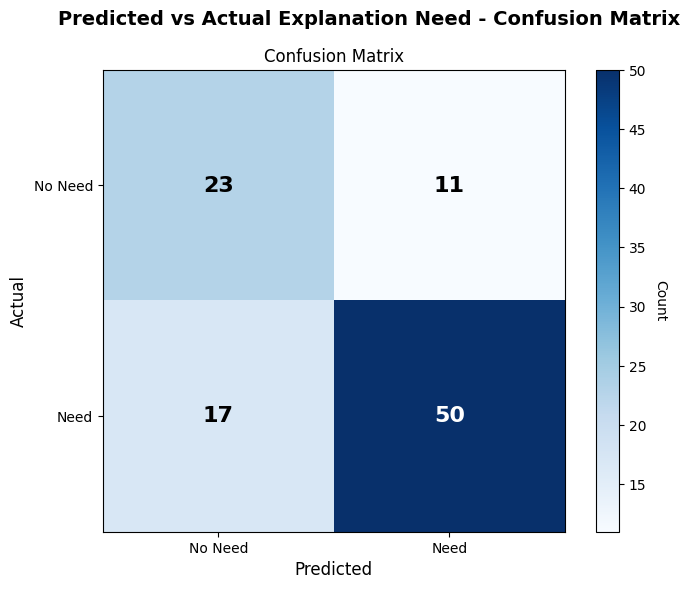

In [ ]:
# Predicted vs Actual Explanation Needed Analysis

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("="*80)
print("PREDICTED vs ACTUAL EXPLANATION NEEDED ANALYSIS")
print("="*80)

# Merge chat sessions with explanation feedback to get predicted vs actual
merged_data = pd.merge(
    df_chat_sessions_filtered[['id', 'user_id', 'explanation_given']],
    df_explanation_feedback_filtered[['session_id', 'user_id', 'was_needed', 'would_have_been_needed']],
    left_on='id', right_on='session_id',
    how='inner'
)

print(f"Successfully merged {len(merged_data)} records for prediction analysis")

# Debug: Check the actual values in the columns
print(f"\nData Validation:")
print(f"- was_needed unique values: {merged_data['was_needed'].unique()}")
print(f"- would_have_been_needed unique values: {merged_data['would_have_been_needed'].unique()}")

# Convert to binary values for analysis
merged_data['predicted_needed'] = merged_data['explanation_given'].astype(int)

# Combine was_needed and would_have_been_needed by taking the non-NaN value
# Since they are complementary, use coalesce logic
merged_data['explanation_actual_needed'] = merged_data['was_needed'].fillna(merged_data['would_have_been_needed'])

print(f"\nData Mapping Validation:")
print(f"- Total merged records: {len(merged_data)}")
print(f"- was_needed values: {merged_data['was_needed'].notna().sum()}")
print(f"- would_have_been_needed values: {merged_data['would_have_been_needed'].notna().sum()}")
print(f"- Combined explanation_actual_needed values: {merged_data['explanation_actual_needed'].notna().sum()}")

# Convert Boolean values to binary (True=1, False=0)
merged_data['actual_needed'] = merged_data['explanation_actual_needed'].astype(int)
print(f"- After binary conversion, non-null actual_needed: {merged_data['actual_needed'].notna().sum()}")
print(f"- actual_needed unique values: {merged_data['actual_needed'].unique()}")

# Remove rows with missing values (where both original columns were NaN)
analysis_data = merged_data.dropna(subset=['predicted_needed', 'actual_needed'])
print(f"\nAnalysis dataset: {len(analysis_data)} complete records")

if len(analysis_data) > 0:
    # Basic statistics
    predicted_rate = analysis_data['predicted_needed'].mean()
    actual_rate = analysis_data['actual_needed'].mean()

    print(f"\nPrediction Statistics:")
    print(f"- Explanation predicted needed: {predicted_rate:.1%} ({analysis_data['predicted_needed'].sum()}/{len(analysis_data)})")
    print(f"- Explanation actually needed: {actual_rate:.1%} ({analysis_data['actual_needed'].sum()}/{len(analysis_data)})")

    # Create contingency table
    contingency_table = pd.crosstab(
        analysis_data['predicted_needed'],
        analysis_data['actual_needed'],
        margins=True
    )

    print(f"\nContingency Table (Predicted vs Actual):")
    print(contingency_table)

    # Create confusion matrix visualization only
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    fig.suptitle('Predicted vs Actual Explanation Need - Confusion Matrix', fontsize=14, fontweight='bold')

    # Define variables for analysis
    y_true = analysis_data['actual_needed']
    y_pred = analysis_data['predicted_needed']

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_true, y_pred)
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.set_title('Confusion Matrix')

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black",
                   fontsize=16, fontweight='bold')

    ax.set_ylabel('Actual', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No Need', 'Need'])
    ax.set_yticklabels(['No Need', 'Need'])

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Count', rotation=270, labelpad=15)

    #plt.tight_layout()
    #plt.show()

    # Detailed Classification Report
    print(f"\nDetailed Classification Report:")
    print("-" * 50)
    print(classification_report(y_true, y_pred, target_names=['No Need', 'Need']))

    # Statistical Analysis
    print(f"\n" + "="*60)
    print("STATISTICAL ANALYSIS")
    print("="*60)

    # Calculate confidence intervals (approximate)
    n = len(analysis_data)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    # 95% confidence interval approximation
    z_score = 1.96  # for 95% CI

    accuracy_se = np.sqrt(accuracy * (1 - accuracy) / n)
    precision_se = np.sqrt(precision * (1 - precision) / (y_pred == 1).sum()) if (y_pred == 1).sum() > 0 else 0
    recall_se = np.sqrt(recall * (1 - recall) / (y_true == 1).sum()) if (y_true == 1).sum() > 0 else 0

    print(f"95% Confidence Intervals:")
    print(f"- Accuracy: {accuracy:.3f} ± {z_score * accuracy_se:.3f}")
    print(f"- Precision: {precision:.3f} ± {z_score * precision_se:.3f}")
    print(f"- Recall: {recall:.3f} ± {z_score * recall_se:.3f}")

    # Error Analysis
    print(f"\nError Analysis:")
    false_positives = ((y_pred == 1) & (y_true == 0)).sum()
    false_negatives = ((y_pred == 0) & (y_true == 1)).sum()
    print(f"- False Positives (System predicted need, but user didn't): {false_positives}")
    print(f"- False Negatives (System didn't predict need, but user did): {false_negatives}")
    print(f"- Error Rate: {(false_positives + false_negatives) / len(analysis_data):.1%}")

else:
    print("Insufficient data for prediction analysis")

print(f"\n" + "="*80)
print("PREDICTION ANALYSIS COMPLETE")
print("="*80)

### F1 Score and performance metrics

In [ ]:
# F1 Score and Performance Metrics by User Level Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("="*80)
print("F1 SCORE AND PERFORMANCE METRICS BY USER LEVEL ANALYSIS")
print("="*80)

# Merge analysis data with user information to get user levels
analysis_with_users = pd.merge(
    analysis_data,
    df_users_filtered[['id', 'user_level_category', 'sql_expertise_level']],
    left_on='user_id_x', right_on='id',  # user_id_x from the merge
    how='left'
)

print(f"Successfully merged {len(analysis_with_users)} records with user level information")

if 'user_level_category' in analysis_with_users.columns:
    # Group by user level and calculate metrics for each group
    user_levels = analysis_with_users['user_level_category'].dropna().unique()

    print(f"\nPerformance Metrics by User Level:")
    print("-" * 80)

    performance_summary = []
    user_level_data = {}

    for level in user_levels:
        level_data = analysis_with_users[analysis_with_users['user_level_category'] == level]

        print(f"\n{level.upper()} USERS (n={len(level_data)}):")

        # Set minimum threshold for meaningful calculation
        min_data_threshold = 3

        if len(level_data) >= min_data_threshold:
            y_true_level = level_data['actual_needed']
            y_pred_level = level_data['predicted_needed']

            # Calculate metrics for this user level (with zero_division handling)
            f1_level = f1_score(y_true_level, y_pred_level, zero_division=0)
            precision_level = precision_score(y_true_level, y_pred_level, zero_division=0)
            recall_level = recall_score(y_true_level, y_pred_level, zero_division=0)
            accuracy_level = accuracy_score(y_true_level, y_pred_level)

            # Prediction rates
            predicted_rate_level = y_pred_level.mean()
            actual_rate_level = y_true_level.mean()

            print(f"- F1 Score: {f1_level:.3f}")
            print(f"- Precision: {precision_level:.3f}")
            print(f"- Recall: {recall_level:.3f}")
            print(f"- Accuracy: {accuracy_level:.3f}")
            print(f"- Predicted needed rate: {predicted_rate_level:.1%}")
            print(f"- Actually needed rate: {actual_rate_level:.1%}")

            # Show confusion matrix for all user levels
            cm_level = confusion_matrix(y_true_level, y_pred_level)
            print(f"Confusion Matrix:")

            # Handle different confusion matrix shapes robustly
            try:
                # Check if we have a 2x2 matrix
                if cm_level.shape == (2, 2):
                    print(f"{'':>12} {'Pred No':>8} {'Pred Yes':>9}")
                    print(f"{'Actual No':>12} {cm_level[0,0]:>8} {cm_level[0,1]:>9}")
                    print(f"{'Actual Yes':>12} {cm_level[1,0]:>8} {cm_level[1,1]:>9}")
                else:
                    # Create a 2x2 representation for single-class scenarios
                    unique_actual = sorted(y_true_level.unique())
                    unique_predicted = sorted(y_pred_level.unique())

                    # Initialize 2x2 matrix with zeros
                    full_cm = np.zeros((2, 2), dtype=int)

                    # Fill in the actual confusion matrix values
                    for i, true_class in enumerate(unique_actual):
                        for j, pred_class in enumerate(unique_predicted):
                            # Map to 2x2 indices (0=No, 1=Yes)
                            true_idx = int(true_class)
                            pred_idx = int(pred_class)
                            full_cm[true_idx, pred_idx] = cm_level[i, j]

                    # Display as standard 2x2 matrix
                    print(f"{'':>12} {'Pred No':>8} {'Pred Yes':>9}")
                    print(f"{'Actual No':>12} {full_cm[0,0]:>8} {full_cm[0,1]:>9}")
                    print(f"{'Actual Yes':>12} {full_cm[1,0]:>8} {full_cm[1,1]:>9}")

                    # Add explanation
                    if len(unique_actual) == 1:
                        actual_class = unique_actual[0]
                        class_name = "Need" if actual_class == 1 else "No Need"
                        print(f"Note: All users actually {class_name} explanations")

            except Exception as e:
                print(f"Error displaying confusion matrix: {e}")
                print(f"Matrix shape: {cm_level.shape}")
                print(f"Raw matrix: {cm_level}")
                print(f"Unique actual values: {y_true_level.unique()}")
                print(f"Unique predicted values: {y_pred_level.unique()}")

            # Add note for single-class scenarios
            if level_data['actual_needed'].nunique() == 1:
                unique_actual = level_data['actual_needed'].unique()[0]
                print(f"Note: Single-class scenario (all actual_needed = {unique_actual})")

            # Store for summary table and visualizations
            performance_summary.append({
                'User_Level': level,
                'Count': len(level_data),
                'F1_Score': f1_level,
                'Precision': precision_level,
                'Recall': recall_level,
                'Accuracy': accuracy_level,
                'Predicted_Rate': predicted_rate_level,
                'Actual_Rate': actual_rate_level
            })

            # Store confusion matrix for visualization
            user_level_data[level] = {
                'confusion_matrix': cm_level,
                'y_true': y_true_level,
                'y_pred': y_pred_level,
                'metrics': {
                    'f1': f1_level,
                    'precision': precision_level,
                    'recall': recall_level,
                    'accuracy': accuracy_level
                }
            }

        else:
            print(f"→ Insufficient data for calculation (n={len(level_data)}, minimum: {min_data_threshold})")

            # Store with "Insufficient data" markers for summary table
            performance_summary.append({
                'User_Level': level,
                'Count': len(level_data),
                'F1_Score': np.nan,
                'Precision': np.nan,
                'Recall': np.nan,
                'Accuracy': np.nan,
                'Predicted_Rate': np.nan,
                'Actual_Rate': np.nan
            })

    # Create summary table
    if performance_summary:
        summary_df = pd.DataFrame(performance_summary)
        summary_df = summary_df.round(3)

        print(f"\n" + "="*80)
        print("PERFORMANCE SUMMARY BY USER LEVEL")
        print("="*80)
        print(summary_df.to_string(index=False))

        # Statistical significance test between groups (if applicable)
        if len([p for p in performance_summary if not pd.isna(p['F1_Score'])]) > 1:
            valid_f1_scores = [p['F1_Score'] for p in performance_summary if not pd.isna(p['F1_Score'])]
            print(f"\nUser Level Comparison:")
            print(f"- F1 Score Range: {min(valid_f1_scores):.3f} - {max(valid_f1_scores):.3f}")
            print(f"- F1 Score Std Dev: {np.std(valid_f1_scores):.3f}")

            # Find best and worst performing user levels
            valid_performance_only = [p for p in performance_summary if not pd.isna(p['F1_Score'])]
            if valid_performance_only:
                best_f1 = max(valid_performance_only, key=lambda x: x['F1_Score'])
                worst_f1 = min(valid_performance_only, key=lambda x: x['F1_Score'])
                print(f"- Best F1 Performance: {best_f1['User_Level']} ({best_f1['F1_Score']:.3f})")
                print(f"- Worst F1 Performance: {worst_f1['User_Level']} ({worst_f1['F1_Score']:.3f})")
else:
    print("User level information not available in merged data")

print(f"\n" + "="*80)
print("USER LEVEL PERFORMANCE ANALYSIS COMPLETE")
print("="*80)

F1 SCORE AND PERFORMANCE METRICS BY USER LEVEL ANALYSIS
Successfully merged 101 records with user level information

Performance Metrics by User Level:
--------------------------------------------------------------------------------

ADVANCED USERS (n=27):
- F1 Score: 0.625
- Precision: 0.833
- Recall: 0.500
- Accuracy: 0.778
- Predicted needed rate: 22.2%
- Actually needed rate: 37.0%
Confusion Matrix:
              Pred No  Pred Yes
   Actual No       16         1
  Actual Yes        5         5

INTERMEDIATE USERS (n=28):
- F1 Score: 0.837
- Precision: 0.900
- Recall: 0.783
- Accuracy: 0.750
- Predicted needed rate: 71.4%
- Actually needed rate: 82.1%
Confusion Matrix:
              Pred No  Pred Yes
   Actual No        3         2
  Actual Yes        5        18

NOVICE USERS (n=16):
- F1 Score: 0.556
- Precision: 0.385
- Recall: 1.000
- Accuracy: 0.500
- Predicted needed rate: 81.2%
- Actually needed rate: 31.2%
Confusion Matrix:
              Pred No  Pred Yes
   Actual No       

#### Overall Performance

In [ ]:
if len(analysis_data) > 0 and analysis_data['actual_needed'].nunique() > 1:
    # Calculate performance metrics
    y_true = analysis_data['actual_needed']
    y_pred = analysis_data['predicted_needed']

    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    print(f"Performance Metrics:")
    print(f"- F1 Score: {f1:.3f}")
    print(f"- Precision: {precision:.3f}")
    print(f"- Recall: {recall:.3f}")
    print(f"- Accuracy: {accuracy:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"{'':>12} {'Predicted No':>12} {'Predicted Yes':>13}")
    print(f"{'Actual No':>12} {cm[0,0]:>12} {cm[0,1]:>13}")
    print(f"{'Actual Yes':>12} {cm[1,0]:>12} {cm[1,1]:>13}")

    # Classification Report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['No Need', 'Need']))
else:
    print("Insufficient data for F1 score calculation")


Performance Metrics:
- F1 Score: 0.781
- Precision: 0.820
- Recall: 0.746
- Accuracy: 0.723

Confusion Matrix:
             Predicted No Predicted Yes
   Actual No           23            11
  Actual Yes           17            50

Detailed Classification Report:
              precision    recall  f1-score   support

     No Need       0.57      0.68      0.62        34
        Need       0.82      0.75      0.78        67

    accuracy                           0.72       101
   macro avg       0.70      0.71      0.70       101
weighted avg       0.74      0.72      0.73       101



#### Performance by user level

In [ ]:
if len(analysis_data) > 0:
    # Merge analysis data with user information to get user levels
    analysis_with_users = pd.merge(
        analysis_data,
        df_users_filtered[['id', 'user_level_category', 'sql_expertise_level']],
        left_on='user_id_x', right_on='id',  # user_id_x from the merge
        how='left'
    )

    print(f"Successfully merged {len(analysis_with_users)} records with user level information")

    if 'user_level_category' in analysis_with_users.columns:
        # Group by user level and calculate metrics for each group
        user_levels = analysis_with_users['user_level_category'].dropna().unique()

        print(f"\nPerformance Metrics by User Level:")
        print("-" * 80)

        performance_summary = []

        for level in user_levels:
            level_data = analysis_with_users[analysis_with_users['user_level_category'] == level]

            print(f"\n{level.upper()} USERS (n={len(level_data)}):")

            # Set minimum threshold for meaningful calculation
            min_data_threshold = 3

            if len(level_data) >= min_data_threshold:
                y_true_level = level_data['actual_needed']
                y_pred_level = level_data['predicted_needed']

                # Calculate metrics for this user level (with zero_division handling)
                f1_level = f1_score(y_true_level, y_pred_level, zero_division=0)
                precision_level = precision_score(y_true_level, y_pred_level, zero_division=0)
                recall_level = recall_score(y_true_level, y_pred_level, zero_division=0)
                accuracy_level = accuracy_score(y_true_level, y_pred_level)

                # Prediction rates
                predicted_rate_level = y_pred_level.mean()
                actual_rate_level = y_true_level.mean()

                print(f"- F1 Score: {f1_level:.3f}")
                print(f"- Precision: {precision_level:.3f}")
                print(f"- Recall: {recall_level:.3f}")
                print(f"- Accuracy: {accuracy_level:.3f}")
                print(f"- Predicted needed rate: {predicted_rate_level:.1%}")
                print(f"- Actually needed rate: {actual_rate_level:.1%}")

                # Show confusion matrix for all user levels
                cm_level = confusion_matrix(y_true_level, y_pred_level)
                print(f"Confusion Matrix:")

                # Handle different confusion matrix shapes robustly
                try:
                    # Check if we have a 2x2 matrix
                    if cm_level.shape == (2, 2):
                        print(f"{'':>12} {'Pred No':>8} {'Pred Yes':>9}")
                        print(f"{'Actual No':>12} {cm_level[0,0]:>8} {cm_level[0,1]:>9}")
                        print(f"{'Actual Yes':>12} {cm_level[1,0]:>8} {cm_level[1,1]:>9}")
                    else:
                        # Create a 2x2 representation for single-class scenarios
                        unique_actual = sorted(y_true_level.unique())
                        unique_predicted = sorted(y_pred_level.unique())

                        # Initialize 2x2 matrix with zeros
                        full_cm = np.zeros((2, 2), dtype=int)

                        # Fill in the actual confusion matrix values
                        for i, true_class in enumerate(unique_actual):
                            for j, pred_class in enumerate(unique_predicted):
                                # Map to 2x2 indices (0=No, 1=Yes)
                                true_idx = int(true_class)
                                pred_idx = int(pred_class)
                                full_cm[true_idx, pred_idx] = cm_level[i, j]

                        # Display as standard 2x2 matrix
                        print(f"{'':>12} {'Pred No':>8} {'Pred Yes':>9}")
                        print(f"{'Actual No':>12} {full_cm[0,0]:>8} {full_cm[0,1]:>9}")
                        print(f"{'Actual Yes':>12} {full_cm[1,0]:>8} {full_cm[1,1]:>9}")

                        # Add explanation
                        if len(unique_actual) == 1:
                            actual_class = unique_actual[0]
                            class_name = "Need" if actual_class == 1 else "No Need"
                            print(f"Note: All users actually {class_name} explanations")

                except Exception as e:
                    print(f"Error displaying confusion matrix: {e}")
                    print(f"Matrix shape: {cm_level.shape}")
                    print(f"Raw matrix: {cm_level}")
                    print(f"Unique actual values: {y_true_level.unique()}")
                    print(f"Unique predicted values: {y_pred_level.unique()}")

                # Add note for single-class scenarios
                if level_data['actual_needed'].nunique() == 1:
                    unique_actual = level_data['actual_needed'].unique()[0]
                    print(f"Note: Single-class scenario (all actual_needed = {unique_actual})")

                # Store for summary table
                performance_summary.append({
                    'User_Level': level,
                    'Count': len(level_data),
                    'F1_Score': f1_level,
                    'Precision': precision_level,
                    'Recall': recall_level,
                    'Accuracy': accuracy_level,
                    'Predicted_Rate': predicted_rate_level,
                    'Actual_Rate': actual_rate_level
                })
            else:
                print(f"→ Insufficient data for calculation (n={len(level_data)}, minimum required: {min_data_threshold})")

                # Store with "Insufficient data" markers for summary table
                performance_summary.append({
                    'User_Level': level,
                    'Count': len(level_data),
                    'F1_Score': "Insufficient data for calculation",
                    'Precision': "Insufficient data for calculation",
                    'Recall': "Insufficient data for calculation",
                    'Accuracy': "Insufficient data for calculation",
                    'Predicted_Rate': "Insufficient data for calculation",
                    'Actual_Rate': "Insufficient data for calculation"
                })

        # Create summary table
        if performance_summary:
            summary_df = pd.DataFrame(performance_summary)
            summary_df = summary_df.round(3)

            print(f"\n" + "="*80)
            print("PERFORMANCE SUMMARY BY USER LEVEL")
            print("="*80)
            print(summary_df.to_string(index=False))

            # Statistical significance test between groups (if applicable)
            if len(performance_summary) > 1:
                print(f"\nUser Level Comparison:")
                f1_scores = [item['F1_Score'] for item in performance_summary]
                print(f"- F1 Score Range: {min(f1_scores):.3f} - {max(f1_scores):.3f}")
                print(f"- F1 Score Std Dev: {np.std(f1_scores):.3f}")

                # Find best and worst performing user levels
                best_f1 = max(performance_summary, key=lambda x: x['F1_Score'])
                worst_f1 = min(performance_summary, key=lambda x: x['F1_Score'])
                print(f"- Best F1 Performance: {best_f1['User_Level']} ({best_f1['F1_Score']:.3f})")
                print(f"- Worst F1 Performance: {worst_f1['User_Level']} ({worst_f1['F1_Score']:.3f})")
    else:
        print("User level information not available in merged data")
else:
    print("No analysis data available for user level breakdown")

Successfully merged 101 records with user level information

Performance Metrics by User Level:
--------------------------------------------------------------------------------

ADVANCED USERS (n=27):
- F1 Score: 0.625
- Precision: 0.833
- Recall: 0.500
- Accuracy: 0.778
- Predicted needed rate: 22.2%
- Actually needed rate: 37.0%
Confusion Matrix:
              Pred No  Pred Yes
   Actual No       16         1
  Actual Yes        5         5

INTERMEDIATE USERS (n=28):
- F1 Score: 0.837
- Precision: 0.900
- Recall: 0.783
- Accuracy: 0.750
- Predicted needed rate: 71.4%
- Actually needed rate: 82.1%
Confusion Matrix:
              Pred No  Pred Yes
   Actual No        3         2
  Actual Yes        5        18

NOVICE USERS (n=16):
- F1 Score: 0.556
- Precision: 0.385
- Recall: 1.000
- Accuracy: 0.500
- Predicted needed rate: 81.2%
- Actually needed rate: 31.2%
Confusion Matrix:
              Pred No  Pred Yes
   Actual No        3         8
  Actual Yes        0         5

BEGINNER U

### Quality of explanation

EXPLANATION QUALITY ANALYSIS
Explanation Quality Statistics (n=12):
- Mean Quality Rating: 3.17
- Median Quality Rating: 3.00
- Standard Deviation: 0.58
- Range: 2 - 4
- Variance: 0.33
- First Quartile (Q1): 3.00
- Third Quartile (Q3): 3.25
- Interquartile Range (IQR): 0.25

Quality Rating Distribution:
- Rating 2: 1 responses (8.3%)
- Rating 3: 8 responses (66.7%)
- Rating 4: 3 responses (25.0%)

Statistical Analysis:
- Shapiro-Wilk normality test: statistic=0.7533, p-value=0.0029
  Non-normal distribution (α=0.05)
- One-sample t-test vs neutral rating (3.0): t=1.0000, p-value=0.3388
  No significant difference from neutral rating


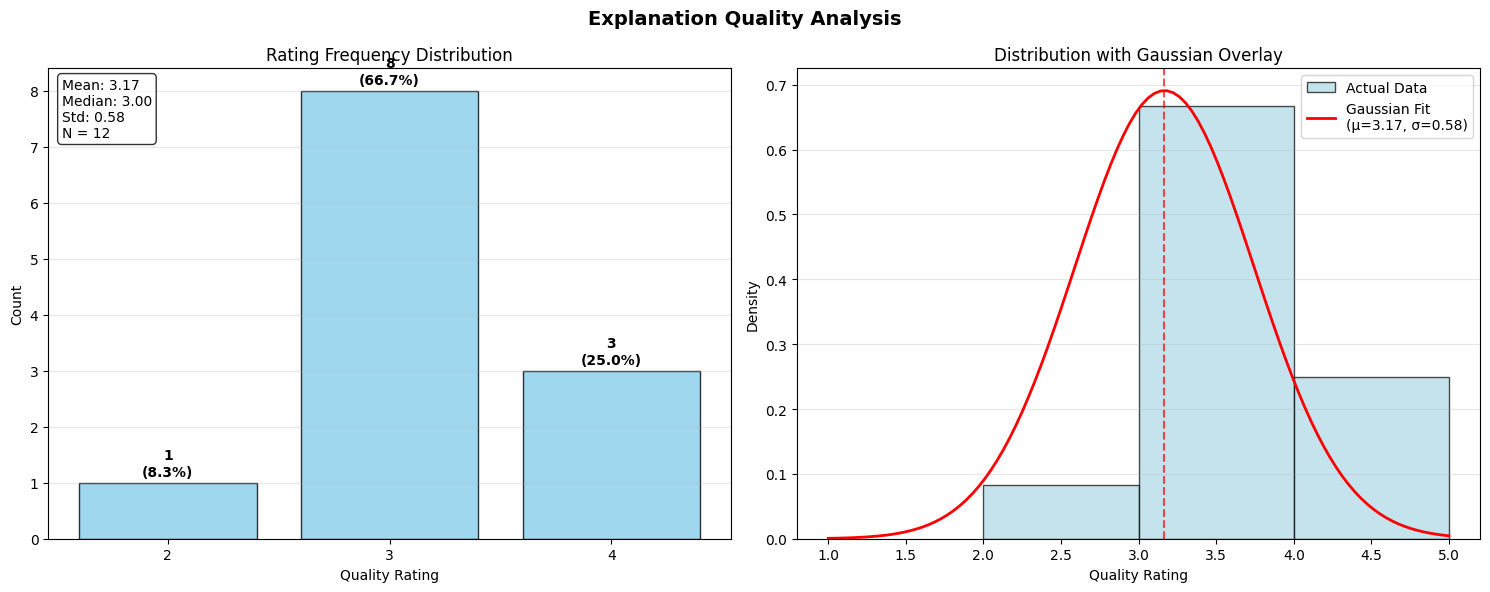


DETAILED STATISTICAL INSIGHTS
Mode (most common rating): 3 (appears 8 times)
Skewness: 0.055 (right-skewed)
Kurtosis: -0.050 (platykurtic (light-tailed))
95% Confidence Interval for mean: [2.800, 3.533]

Quality Rating Interpretation:
- Overall Assessment: Moderate - Users rate explanation quality as acceptable to good
- 3/12 (25.0%) users rated quality as good or excellent
- 1/12 (8.3%) users rated quality as poor

Recommendations:
- Explanation quality is acceptable but has room for improvement
- Focus on enhancing clarity and relevance
- Consider A/B testing different explanation approaches

EXPLANATION QUALITY ANALYSIS COMPLETE


In [ ]:
# Explanation Quality Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("="*80)
print("EXPLANATION QUALITY ANALYSIS")
print("="*80)

if 'explanation_quality_rating' in df_comprehensive_feedback_filtered.columns:
    quality_data = df_comprehensive_feedback_filtered['explanation_quality_rating'].dropna()

    if len(quality_data) > 0:
        print(f"Explanation Quality Statistics (n={len(quality_data)}):")
        print(f"- Mean Quality Rating: {quality_data.mean():.2f}")
        print(f"- Median Quality Rating: {quality_data.median():.2f}")
        print(f"- Standard Deviation: {quality_data.std():.2f}")
        print(f"- Range: {quality_data.min()} - {quality_data.max()}")
        print(f"- Variance: {quality_data.var():.2f}")

        # Calculate quartiles and IQR
        q25 = quality_data.quantile(0.25)
        q75 = quality_data.quantile(0.75)
        iqr = q75 - q25
        print(f"- First Quartile (Q1): {q25:.2f}")
        print(f"- Third Quartile (Q3): {q75:.2f}")
        print(f"- Interquartile Range (IQR): {iqr:.2f}")

        # Distribution of ratings
        print(f"\nQuality Rating Distribution:")
        quality_dist = quality_data.value_counts().sort_index()
        for rating, count in quality_dist.items():
            percentage = (count / len(quality_data)) * 100
            print(f"- Rating {rating}: {count} responses ({percentage:.1f}%)")

        # Statistical tests
        print(f"\nStatistical Analysis:")
        # Test for normality (Shapiro-Wilk test)
        if len(quality_data) >= 3:
            shapiro_stat, shapiro_p = stats.shapiro(quality_data)
            print(f"- Shapiro-Wilk normality test: statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
            print(f"  {'Normal distribution' if shapiro_p > 0.05 else 'Non-normal distribution'} (α=0.05)")

        # One-sample t-test against neutral rating (assuming 3 is neutral on a 5-point scale)
        neutral_rating = 3.0
        if len(quality_data) > 1:
            t_stat, t_p = stats.ttest_1samp(quality_data, neutral_rating)
            print(f"- One-sample t-test vs neutral rating ({neutral_rating}): t={t_stat:.4f}, p-value={t_p:.4f}")
            if t_p < 0.05:
                direction = "significantly higher" if quality_data.mean() > neutral_rating else "significantly lower"
                print(f"  Quality rating is {direction} than neutral")
            else:
                print(f"  No significant difference from neutral rating")

        # Create bar chart combined with gaussian distribution
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle('Explanation Quality Analysis', fontsize=14, fontweight='bold')

        # 1. Bar chart of rating frequencies
        rating_counts = quality_dist
        bars = ax1.bar(rating_counts.index, rating_counts.values,
                      color='skyblue', alpha=0.8, edgecolor='black')
        ax1.set_title('Rating Frequency Distribution')
        ax1.set_xlabel('Quality Rating')
        ax1.set_ylabel('Count')
        ax1.set_xticks(rating_counts.index)
        ax1.grid(axis='y', alpha=0.3)

        # Add percentage labels on bars
        total_responses = len(quality_data)
        for bar, count in zip(bars, rating_counts.values):
            height = bar.get_height()
            percentage = (count / total_responses) * 100
            ax1.annotate(f'{count}\n({percentage:.1f}%)',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontweight='bold')

        # Add statistics text
        stats_text = f'Mean: {quality_data.mean():.2f}\nMedian: {quality_data.median():.2f}\nStd: {quality_data.std():.2f}\nN = {len(quality_data)}'
        ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # 2. Gaussian distribution overlay
        # Create histogram
        n, bins, patches = ax2.hist(quality_data, bins=range(int(quality_data.min()), int(quality_data.max()) + 2),
                                   alpha=0.7, color='lightblue', edgecolor='black', density=True, label='Actual Data')

        # Fit and plot Gaussian
        mu = quality_data.mean()
        sigma = quality_data.std()

        # Create smooth curve
        x = np.linspace(quality_data.min() - 1, quality_data.max() + 1, 100)
        gaussian = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

        ax2.plot(x, gaussian, 'r-', linewidth=2, label=f'Gaussian Fit\n(μ={mu:.2f}, σ={sigma:.2f})')
        ax2.set_title('Distribution with Gaussian Overlay')
        ax2.set_xlabel('Quality Rating')
        ax2.set_ylabel('Density')
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)

        # Add mean line
        ax2.axvline(mu, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mu:.2f}')

        plt.tight_layout()
        plt.show()

        # Additional statistical insights
        print(f"\n" + "="*60)
        print("DETAILED STATISTICAL INSIGHTS")
        print("="*60)

        # Mode calculation
        mode_result = stats.mode(quality_data, keepdims=True)
        print(f"Mode (most common rating): {mode_result.mode[0]} (appears {mode_result.count[0]} times)")

        # Skewness and kurtosis
        skewness = stats.skew(quality_data)
        kurtosis = stats.kurtosis(quality_data)
        print(f"Skewness: {skewness:.3f} ({'right-skewed' if skewness > 0 else 'left-skewed' if skewness < 0 else 'symmetric'})")
        print(f"Kurtosis: {kurtosis:.3f} ({'leptokurtic (heavy-tailed)' if kurtosis > 0 else 'platykurtic (light-tailed)' if kurtosis < 0 else 'mesokurtic (normal-tailed)'})")

        # Confidence interval for the mean
        confidence_level = 0.95
        alpha = 1 - confidence_level
        se = stats.sem(quality_data)
        h = se * stats.t.ppf((1 + confidence_level) / 2., len(quality_data) - 1)
        print(f"{confidence_level*100:.0f}% Confidence Interval for mean: [{quality_data.mean() - h:.3f}, {quality_data.mean() + h:.3f}]")

        # Rating interpretation
        mean_rating = quality_data.mean()
        if mean_rating >= 4:
            interpretation = "High - Users rate explanation quality as good to excellent"
        elif mean_rating >= 3:
            interpretation = "Moderate - Users rate explanation quality as acceptable to good"
        elif mean_rating >= 2:
            interpretation = "Low - Users rate explanation quality as poor to acceptable"
        else:
            interpretation = "Very Low - Users rate explanation quality as poor"

        print(f"\nQuality Rating Interpretation:")
        print(f"- Overall Assessment: {interpretation}")
        print(f"- {(quality_data >= 4).sum()}/{len(quality_data)} ({(quality_data >= 4).sum()/len(quality_data)*100:.1f}%) users rated quality as good or excellent")
        print(f"- {(quality_data <= 2).sum()}/{len(quality_data)} ({(quality_data <= 2).sum()/len(quality_data)*100:.1f}%) users rated quality as poor")

        # Recommendations based on data
        print(f"\nRecommendations:")
        if mean_rating < 3:
            print("- Explanation quality needs significant improvement")
            print("- Consider revising explanation generation algorithms")
            print("- Gather detailed feedback on specific issues")
        elif mean_rating < 4:
            print("- Explanation quality is acceptable but has room for improvement")
            print("- Focus on enhancing clarity and relevance")
            print("- Consider A/B testing different explanation approaches")
        else:
            print("- Explanation quality is performing well")
            print("- Maintain current standards while monitoring for consistency")
            print("- Consider what makes explanations successful for future development")

    else:
        print("No quality rating data available for analysis")
else:
    print("explanation_quality_rating column not found in the dataset")

print(f"\n" + "="*80)
print("EXPLANATION QUALITY ANALYSIS COMPLETE")
print("="*80)

### Trust and recommendation

In [ ]:
# =============================================================================
# TEXT-ONLY PAIRWISE COMPARISON
# Focus: System Helpfulness
# Pairs: (Automatic vs Intelligent) and (Manual Trigger vs Intelligent)
# =============================================================================
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("TRUST & RECOMMENDATION — STRICT PAIRWISE COMPARISON (TEXT ONLY)")
print("="*80)

# ---- 0) Input frame ----
feedback_data = df_comprehensive_feedback_filtered.copy()
print("Columns:", list(feedback_data.columns))
print(f"Total records: {len(feedback_data)}")

# ---- 1) System helpfulness aliasing ----
helpfulness_aliases = [
    "system_helpfulness_rating",
    "system_helpfulness",
    "helpfulness_rating",
    "system_helpfulness_index"
]
helpfulness_col = next((c for c in helpfulness_aliases if c in feedback_data.columns), None)
if not helpfulness_col:
    raise ValueError("No system helpfulness metric found. Please ensure one of: "
                     f"{helpfulness_aliases}")

# Optional additional metrics (if you want them in the same pairwise printout)
optional_metrics = [
    "recommendation_index",
    "explanation_quality_rating",
    "system_accuracy_index",
]
metrics = [helpfulness_col] + [m for m in optional_metrics if m in feedback_data.columns]

print(f"Using system helpfulness column: {helpfulness_col}")
if len(metrics) > 1:
    print("Also available:", [m for m in metrics if m != helpfulness_col])

# ---- 2) Classify explanation types (exclusive) ----
if 'auto_explanation' not in feedback_data.columns:
    raise ValueError("Required column 'auto_explanation' not found.")
# 'manual_trigger' optional; treat missing as False
def classify_explanation_type(auto_exp, manual_trig):
    auto_flag = bool(auto_exp) if pd.notna(auto_exp) else False
    manual_flag = False
    if 'manual_trigger' in feedback_data.columns and pd.notna(manual_trig):
        if isinstance(manual_trig, bool):
            manual_flag = manual_trig
        else:
            s = str(manual_trig).strip().lower()
            manual_flag = s not in ("", "no", "none", "false", "0", "nan")
    if auto_flag:
        return "automatic_explanation"
    if manual_flag:
        return "manual_trigger"
    return "intelligent_explanation"

feedback_data['explanation_type'] = feedback_data.apply(
    lambda r: classify_explanation_type(r.get('auto_explanation'), r.get('manual_trigger')),
    axis=1
)

# ---- 3) Pairwise-only comparison helpers ----
def cliffs_delta(x, y):
    x, y = np.asarray(x), np.asarray(y)
    greater = sum(xi > yj for xi in x for yj in y)
    less    = sum(xi < yj for xi in x for yj in y)
    return (greater - less) / (len(x) * len(y))

def delta_magnitude(d):
    a = abs(d)
    if a < 0.147: return "negligible"
    if a < 0.330: return "small"
    if a < 0.474: return "medium"
    return "large"

def compare_pair(df, type_a, type_b, metrics, title):
    """Strictly compare only rows of type_a and type_b; drop all others."""
    print("\n" + "-"*80)
    print(title.upper())
    print("-"*80)
    sub = df[df['explanation_type'].isin([type_a, type_b])].copy()
    print(f"Filtered rows for this pair: {len(sub)} "
          f"(kept only: {type_a}, {type_b})")

    grp_a = sub[sub['explanation_type'] == type_a]
    grp_b = sub[sub['explanation_type'] == type_b]
    print(f"Group sizes: {type_a} (n={len(grp_a)}), {type_b} (n={len(grp_b)})")

    if len(grp_a) == 0 or len(grp_b) == 0:
        print("[INFO] One group empty; skipping this pair.")
        return

    for m in metrics:
        a_vals = grp_a[m].dropna()
        b_vals = grp_b[m].dropna()
        print(f"\nMetric: {m.replace('_',' ').title()}")
        print(f"  {type_a.replace('_',' ').title()}: median={a_vals.median():.2f}, mean={a_vals.mean():.2f}, n={len(a_vals)}")
        print(f"  {type_b.replace('_',' ').title()}: median={b_vals.median():.2f}, mean={b_vals.mean():.2f}, n={len(b_vals)}")

        if len(a_vals) >= 3 and len(b_vals) >= 3:
            try:
                stat, p = stats.mannwhitneyu(a_vals, b_vals, alternative='two-sided')
                d = cliffs_delta(a_vals, b_vals)
                winner = ("Tie", 0.0)
                if a_vals.median() > b_vals.median():
                    winner = (type_a.replace('_',' ').title(), a_vals.median() - b_vals.median())
                elif b_vals.median() > a_vals.median():
                    winner = (type_b.replace('_',' ').title(), b_vals.median() - a_vals.median())
                print(f"  Mann–Whitney U p-value: {p:.4f}")
                print(f"  Cliff's delta: {d:.3f} ({delta_magnitude(d)})")
                print(f"  Preference (by median): {winner[0]} (+{winner[1]:.2f})")
            except Exception as e:
                print(f"  [WARN] Statistical test failed: {e}")
        else:
            print("  [INFO] Not enough data for statistical test (need ≥3 per group).")

# ---- 4) Run the two required pairwise comparisons only ----
types_present = set(feedback_data['explanation_type'].unique())
must_have_1 = {"automatic_explanation", "intelligent_explanation"}
must_have_2 = {"manual_trigger", "intelligent_explanation"}

if must_have_1.issubset(types_present):
    compare_pair(
        feedback_data,
        "automatic_explanation",
        "intelligent_explanation",
        metrics,
        title="Automatic Explanation vs Intelligent Explanation"
    )
else:
    print("\n[INFO] Skipping 'Automatic vs Intelligent' — one or both types not present.")

if must_have_2.issubset(types_present):
    compare_pair(
        feedback_data,
        "manual_trigger",
        "intelligent_explanation",
        metrics,
        title="Manual Trigger vs Intelligent Explanation"
    )
else:
    print("\n[INFO] Skipping 'Manual Trigger vs Intelligent' — one or both types not present.")

print("\n" + "="*80)
print("PAIRWISE COMPARISON COMPLETE")
print("="*80)


TRUST & RECOMMENDATION — STRICT PAIRWISE COMPARISON (TEXT ONLY)
Columns: ['id', 'user_id', 'frequency_rating', 'frequency_reason', 'explanation_quality_rating', 'explanation_quality_reason', 'system_helpfulness_rating', 'system_helpfulness_reason', 'learning_improvement_rating', 'learning_improvement_reason', 'auto_explanation', 'auto_reason', 'system_accuracy', 'system_accuracy_index', 'recommendation', 'recommendation_index', 'created_at', 'manual_trigger', 'manual_reason']
Total records: 12
Using system helpfulness column: system_helpfulness_rating
Also available: ['recommendation_index', 'explanation_quality_rating', 'system_accuracy_index']

--------------------------------------------------------------------------------
AUTOMATIC EXPLANATION VS INTELLIGENT EXPLANATION
--------------------------------------------------------------------------------
Filtered rows for this pair: 8 (kept only: automatic_explanation, intelligent_explanation)
Group sizes: automatic_explanation (n=2), i

In [ ]:
df_users_filtered

,id,username,password_hash,role,created_at,last_login,sql_expertise_level,cognitive_load_capacity,has_completed_assessment,sql_expertise,...,forecasting_statistics,data_visualization,domain_knowledge_retail,total_assessment_score,user_level_category,age,gender,profession,education_level,study_training
1,14,User_001,15e2b0d3c33891ebb0f1ef609ec419420c20e320ce94c6...,user,2025-08-25 18:40:02.907155,2025-08-25 19:09:51.364711,3,1,True,0,...,4,0,4,13,Intermediate,22.0,Male,Student,Bachelor,BAE
2,21,User_002,ecd71870d1963316a97e3ac3408c9835ad8cf0f3c1bc70...,user,2025-08-29 13:53:17.979671,2025-08-29 14:16:29.290583,5,2,True,4,...,4,2,2,20,Advanced,27.0,Male,NaN,Master,Mathematik
3,24,User_003,ecd71870d1963316a97e3ac3408c9835ad8cf0f3c1bc70...,user,2025-08-29 19:03:15.214020,2025-08-29 19:03:17.201197,1,1,True,0,...,0,0,0,3,Beginner,31.0,NaN,NaN,Bachelor,Kulturwirtschaft
4,6,User_004,e9648f05c54fd6f53bf5b1ddfc3faa3cf93c1f86eeb82a...,user,2025-08-22 14:19:23.986310,2025-08-22 14:19:25.982002,4,2,True,4,...,1,4,4,18,Advanced,25.0,Female,Student,Master,Information Systems
5,18,User_005,ecd71870d1963316a97e3ac3408c9835ad8cf0f3c1bc70...,user,2025-08-28 17:23:22.538451,2025-08-28 17:23:24.539626,1,1,True,0,...,0,0,0,2,Beginner,19.0,Male,NaN,Bachlore,Jura
6,13,User_006,ecd71870d1963316a97e3ac3408c9835ad8cf0f3c1bc70...,user,2025-08-25 14:39:29.213330,2025-08-25 20:58:11.703300,4,2,True,2,...,0,4,4,16,Advanced,27.0,Male,Kaufmann für Groß-und Außenhandel,Mittlere Reife,none
7,7,User_007,8d969eef6ecad3c29a3a629280e686cf0c3f5d5a86aff3...,user,2025-08-22 14:46:45.860408,2025-08-22 14:54:53.217247,3,1,True,3,...,2,2,1,12,Intermediate,23.0,Male,Student,Bachelor,Wirtschaftsinformatik
10,11,User_010,101735a1ab5b123f17b02a8b9f2d662cee3a0d6d081607...,user,2025-08-24 14:04:26.195468,2025-08-24 16:22:12.814567,4,2,True,1,...,4,2,2,17,Advanced,21.0,Male,Student,Bachelor,Information systems
15,19,User_015,ecd71870d1963316a97e3ac3408c9835ad8cf0f3c1bc70...,user,2025-08-29 12:08:00.716716,2025-08-29 12:45:52.361097,3,1,True,0,...,4,0,0,12,Intermediate,22.0,Male,NaN,Bachelore,BAE
16,4,User_016,4389dccef84151b2987f4a21d0286fcbad0d7b81bbe9ec...,user,2025-08-19 11:01:48.653451,2025-08-19 11:02:52.721340,4,2,True,1,...,4,4,1,18,Advanced,22.0,Male,Student,Bachelor,Business Adminstration
